In [3]:
#import sys
#!{sys.executable} -m pip install m2w64-toolchain
import numpy as np
import scipy
from scipy.stats import norm
import pandas as pd
import arviz as az
import pymc3 as pm
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
def correlations():

    # Load nutrition data
    df_tesco_msoa = pd.read_csv('year_msoa_grocery.csv', encoding='utf-8', header=0)
    df_tesco_ward = pd.read_csv('year_osward_grocery.csv', encoding='utf-8', header=0)
    df_tesco_oslaua = pd.read_csv('year_borough_grocery.csv', encoding='utf-8', header=0)

    # Load health data
    df_child_obesity_ward = pd.read_csv('child_obesity_london_ward_2013-2014.csv', encoding='utf-8', header=0).dropna()
    df_child_obesity_oslaua = pd.read_csv('child_obesity_london_borough_2015-2016.csv', encoding='utf-8', header=0).dropna()
    df_adult_obesity_oslaua = pd.read_csv('london_obesity_borough_2012.csv', encoding='utf-8', header=0).dropna()
    df_adult_obesity_hospital_oslaua = pd.read_csv('obesity_hospitalization_borough_2016.csv', encoding='utf-8',
                                                   header=0).dropna()
    df_diabetes_ward = pd.read_csv('diabetes_estimates_osward_2016.csv', encoding='utf-8', header=0).dropna()

    outfile = open('correlations_health_outcomes.csv', 'wt', encoding='utf-8')
    outfile.write('outcome,nutrient,r,p\n')

    food_indicators = ['energy_tot', 'energy_fat', 'energy_saturate', 'energy_sugar', 'energy_protein', 'energy_carb',
                       'energy_fibre', 'h_nutrients_calories_norm']
    food_indicators_labels = ['energy', 'fat', 'saturate', 'sugar', 'protein', 'carb', 'fibre', 'diversity']

    # Correlation with child obesity at Ward level
    df_join = df_tesco_ward.merge(df_child_obesity_ward, how='inner')
    plot_labels = ['Prevalence of overweight\nchildren (reception)', 'Prevalence of overweight\nchildren (year 6)',
                   'Prevalence of obese\nchildren (reception)', 'Prevalence of obese\nchildren (year 6)']
    outcomes = ['prevalence_overweight_reception', 'prevalence_overweight_y6', 'prevalence_obese_reception', 'prevalence_obese_y6']

    for b, lab in zip(outcomes, plot_labels):
        correl = []
        nutrient = []
        for a, al in zip(food_indicators, food_indicators_labels):
            r, p = scipy.stats.spearmanr(df_join[a], df_join[b])
            if p < 0.05:
                outfile.write('%s,%s,%s,%s\n' % (b, al, r, p))
                correl.append(r)
                nutrient.append(al)

    # Correlation with adult obesity
    df_join = df_tesco_oslaua.merge(df_adult_obesity_oslaua, how='inner')
    plot_labels = ['Prevalence of\noverweight adults', 'Prevalence of\nobese adults']
    outcomes = ['f_overweight', 'f_obese']
    for b, lab in zip(outcomes, plot_labels):
        correl = []
        nutrient = []
        for a, al in zip(food_indicators, food_indicators_labels):
            r, p = scipy.stats.spearmanr(df_join[a], df_join[b])
            if p < 0.05:
                # print(b,al,r,p)
                outfile.write('%s,%s,%s,%s\n' % (b, al, r, p))
                correl.append(r)
                nutrient.append(al)

    # Correlation with diabetes estimates
    df_join_diabetes = df_tesco_ward.merge(df_diabetes_ward, how='inner')
    plot_labels = ['Diabetes\nprevalence']
    outcomes = ['estimated_diabetes_prevalence']
    for b, lab in zip(outcomes, plot_labels):
        correl = []
        nutrient = []
        for a, al in zip(food_indicators, food_indicators_labels):
            r, p = scipy.stats.spearmanr(df_join_diabetes[a], df_join_diabetes[b])
            if p < 0.05:
                # print(b,al,r,p)
                outfile.write('%s,%s,%s,%s\n' % (b, al, r, p))
                correl.append(r)
                nutrient.append(al)

    outfile.close()

correlations()

<AxesSubplot:>

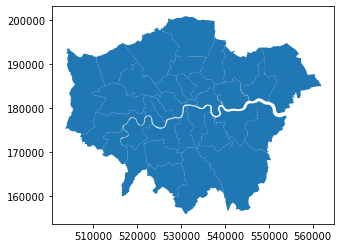

In [5]:
shapefile = "statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp"
map_df = gpd.read_file(shapefile)
map_df.plot()

In [36]:
df_tesco_oslaua = pd.read_csv('year_borough_grocery.csv', encoding='utf-8', header=0)
df_tesco_oslaua.dtypes

area_id              object
weight              float64
weight_perc2.5      float64
weight_perc25       float64
weight_perc50       float64
                     ...   
age_18_64           float64
age_65+             float64
avg_age             float64
area_sq_km          float64
people_per_sq_km    float64
Length: 202, dtype: object

In [6]:
df_tesco_oslaua = pd.read_csv('year_borough_grocery.csv', encoding='utf-8', header=0)
df_child_obesity_oslaua = pd.read_csv('child_obesity_london_borough_2015-2016.csv', encoding='utf-8', header=0).dropna()
df_adult_obesity_oslaua = pd.read_csv('london_obesity_borough_2012.csv', encoding='utf-8', header=0).dropna()
df_london_sport = pd.read_csv('sports_participation_borough.csv', encoding='utf-8', header=0).dropna()
merged = map_df.set_index('GSS_CODE').join(df_tesco_oslaua.set_index('area_id'))
merged = merged.join(df_child_obesity_oslaua.set_index('area_id'))
merged = merged.join(df_adult_obesity_oslaua.set_index('area_id'))
merged.head()

,NAME,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,weight,weight_perc2.5,weight_perc25,...,number_reception_measured,number_y6_measured,prevalence_overweight_reception,prevalence_overweight_y6,prevalence_obese_reception,prevalence_obese_y6,f_healthy_weight,f_overweight,f_obese,weighted_sample
GSS_CODE,,,,,,,,,,,,,,,,,,,,,
E09000021,Kingston upon Thames,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",297.379174,30.0,125.0,...,1889.0,1661.0,8.840656,12.763396,5.505558,16.977724,44.4,40.5,14.6,398
E09000008,Croydon,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",353.636123,30.0,150.0,...,4662.0,3985.0,11.304161,14.203262,10.210210,24.717691,36.6,37.7,24.3,858
E09000006,Bromley,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",319.336273,30.0,135.0,...,3815.0,3220.0,12.581914,13.354037,8.020970,16.180124,34.3,43.8,21.2,743
E09000018,Hounslow,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",336.922944,32.5,150.0,...,3465.0,2774.0,10.447330,15.032444,10.274170,24.333093,35.4,41.0,21.8,628
E09000009,Ealing,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",358.569245,35.0,154.0,...,4233.0,3576.0,12.000945,14.681208,10.559887,23.937360,42.1,39.0,18.2,807


In [7]:
df_london_income = pd.read_csv('london_income.csv', encoding='utf-8', header=0).dropna()
merged = merged.set_index('NAME').join(df_london_income.set_index('NAME'))
merged.head()

,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,weight,weight_perc2.5,weight_perc25,weight_perc50,...,number_y6_measured,prevalence_overweight_reception,prevalence_overweight_y6,prevalence_obese_reception,prevalence_obese_y6,f_healthy_weight,f_overweight,f_obese,weighted_sample,weekly_income
NAME,,,,,,,,,,,,,,,,,,,,,
Kingston upon Thames,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",297.379174,30.0,125.0,220.0,...,1661.0,8.840656,12.763396,5.505558,16.977724,44.4,40.5,14.6,398,566.7
Croydon,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",353.636123,30.0,150.0,250.0,...,3985.0,11.304161,14.203262,10.210210,24.717691,36.6,37.7,24.3,858,512.3
Bromley,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",319.336273,30.0,135.0,250.0,...,3220.0,12.581914,13.354037,8.020970,16.180124,34.3,43.8,21.2,743,584.3
Hounslow,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",336.922944,32.5,150.0,250.0,...,2774.0,10.447330,15.032444,10.274170,24.333093,35.4,41.0,21.8,628,500.9
Ealing,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",358.569245,35.0,154.0,275.0,...,3576.0,12.000945,14.681208,10.559887,23.937360,42.1,39.0,18.2,807,498.3


In [8]:
df_london_sport = pd.read_csv('sports_participation_borough.csv', encoding='utf-8', header=0).dropna()
merged = merged.join(df_london_sport.set_index('NAME'))
merged.head()

,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,weight,weight_perc2.5,weight_perc25,weight_perc50,...,f_obese,weighted_sample,weekly_income,area_id,par1_perc_2012,par1_pop_2012,par3_perc_2012,par3_pop_2012,par0_perc_2012,par0_pop_2012
NAME,,,,,,,,,,,,,,,,,,,,,
Kingston upon Thames,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",297.379174,30.0,125.0,220.0,...,14.6,398,566.7,E09000021,0.418,55400.0,0.195,25800.0,0.440,58400.0
Croydon,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",353.636123,30.0,150.0,250.0,...,24.3,858,512.3,E09000008,0.368,106000.0,0.174,50100.0,0.515,148600.0
Bromley,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",319.336273,30.0,135.0,250.0,...,21.2,743,584.3,E09000006,0.417,105000.0,0.187,47200.0,0.455,114600.0
Hounslow,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",336.922944,32.5,150.0,250.0,...,21.8,628,500.9,E09000018,0.328,67400.0,0.164,33600.0,0.526,108200.0
Ealing,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",358.569245,35.0,154.0,275.0,...,18.2,807,498.3,E09000009,0.373,100900.0,0.208,56300.0,0.498,134800.0


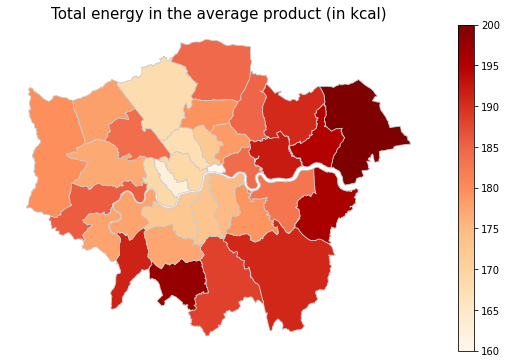

In [9]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='energy_tot', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Total energy in the average product (in kcal)', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=160, vmax=200))
sm._A = []
cbar = fig.colorbar(sm)

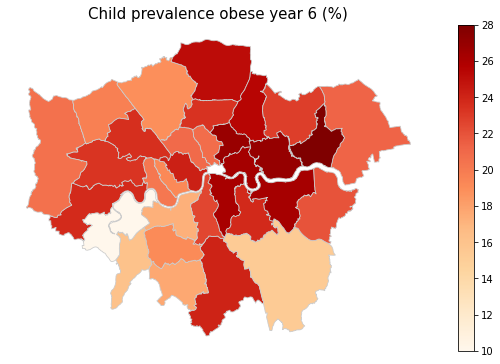

In [10]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='prevalence_obese_y6', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Child prevalence obese year 6 (%)', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=10, vmax=28))
sm._A = []
cbar = fig.colorbar(sm)

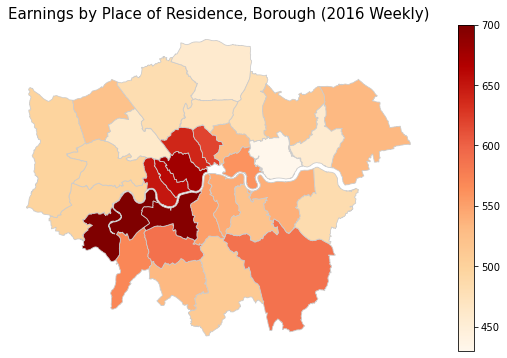

In [11]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='weekly_income', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Earnings by Place of Residence, Borough (2016 Weekly)', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=430, vmax=700))
sm._A = []
cbar = fig.colorbar(sm)

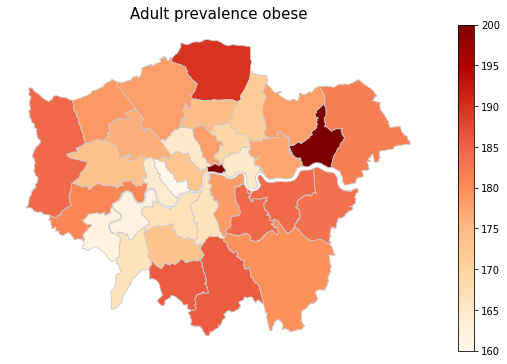

In [12]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='f_obese', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Adult prevalence obese', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=160, vmax=200))
sm._A = []
cbar = fig.colorbar(sm)

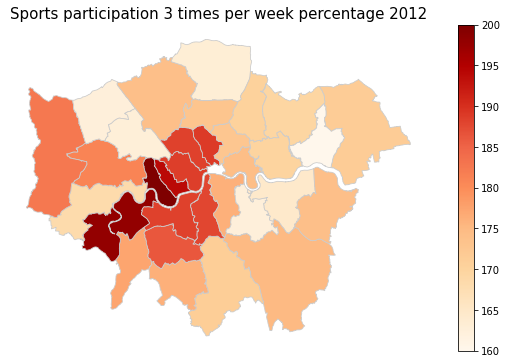

In [13]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='par3_perc_2012', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Sports participation 3 times per week percentage 2012', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=160, vmax=200))
sm._A = []
cbar = fig.colorbar(sm)

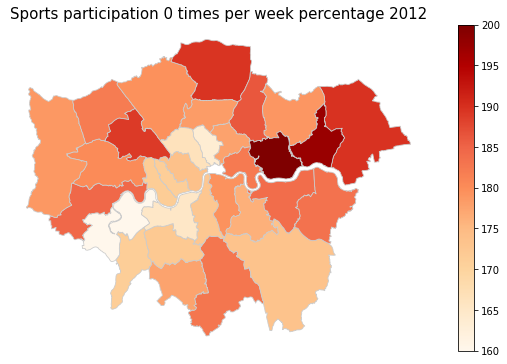

In [14]:
fig, ax = plt.subplots(1,figsize=(10,6))
merged.plot(column='par0_perc_2012', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Sports participation 0 times per week percentage 2012', fontdict={'fontsize': '15'})
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=160, vmax=200))
sm._A = []
cbar = fig.colorbar(sm)

# Correlation

In [45]:
data = merged[["energy_tot", "energy_fat", "energy_saturate", "energy_sugar", "energy_protein", "energy_carb", "energy_fibre", "h_nutrients_calories"
              , "number_y6_measured", "prevalence_overweight_reception", "prevalence_overweight_y6", "prevalence_obese_reception", "prevalence_obese_y6", "f_healthy_weight", "f_overweight", "f_obese", "weekly_income", 
              "par1_perc_2012", "par3_perc_2012", "par0_perc_2012"]]
data = data.dropna()
data

,energy_tot,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories,number_y6_measured,prevalence_overweight_reception,prevalence_overweight_y6,prevalence_obese_reception,prevalence_obese_y6,f_healthy_weight,f_overweight,f_obese,weekly_income,par1_perc_2012,par3_perc_2012,par0_perc_2012
NAME,,,,,,,,,,,,,,,,,,,,
Kingston upon Thames,184.954555,83.645165,32.065465,43.881683,21.422725,74.988869,3.248003,1.569158,1661.0,8.840656,12.763396,5.505558,16.977724,44.4,40.5,14.6,566.7,0.418,0.195,0.440
Croydon,183.154702,81.839970,31.768045,43.877493,20.703677,76.064924,2.973780,1.556777,3985.0,11.304161,14.203262,10.210210,24.717691,36.6,37.7,24.3,512.3,0.368,0.174,0.515
Bromley,184.657955,82.107490,32.012315,44.874947,20.907180,76.702113,3.027731,1.567786,3220.0,12.581914,13.354037,8.020970,16.180124,34.3,43.8,21.2,584.3,0.417,0.187,0.455
Hounslow,181.632016,83.368629,32.885357,41.598085,21.132433,72.341016,3.156904,1.568442,2774.0,10.447330,15.032444,10.274170,24.333093,35.4,41.0,21.8,500.9,0.328,0.164,0.526
Ealing,176.191320,81.109372,32.297035,38.408952,21.473900,68.852826,3.115724,1.580769,3576.0,12.000945,14.681208,10.559887,23.937360,42.1,39.0,18.2,498.3,0.373,0.208,0.498
Havering,190.274533,83.253226,31.899277,45.821912,21.500878,81.002080,3.111010,1.551112,2665.0,12.413793,15.309568,10.771757,21.951220,36.1,41.0,22.3,532.6,0.329,0.175,0.559
Hillingdon,177.963153,79.477669,32.444691,40.618328,21.249241,72.370626,3.006661,1.581566,3295.0,10.328185,15.993930,9.459459,21.244310,32.6,43.5,23.7,499.8,0.426,0.213,0.489
Harrow,176.790789,78.886456,32.088868,40.204457,20.035288,73.404241,3.023350,1.558965,2506.0,9.236412,15.482841,8.402801,20.430966,37.2,38.3,20.8,522.8,0.354,0.144,0.510
Brent,180.510586,80.662196,32.039220,40.594440,20.531658,74.905905,2.963531,1.555736,3540.0,11.157674,15.451977,10.555265,24.152542,43.9,34.9,19.5,467.0,0.326,0.145,0.554


Text(0.5, 1.0, 'Correlation Matrix')

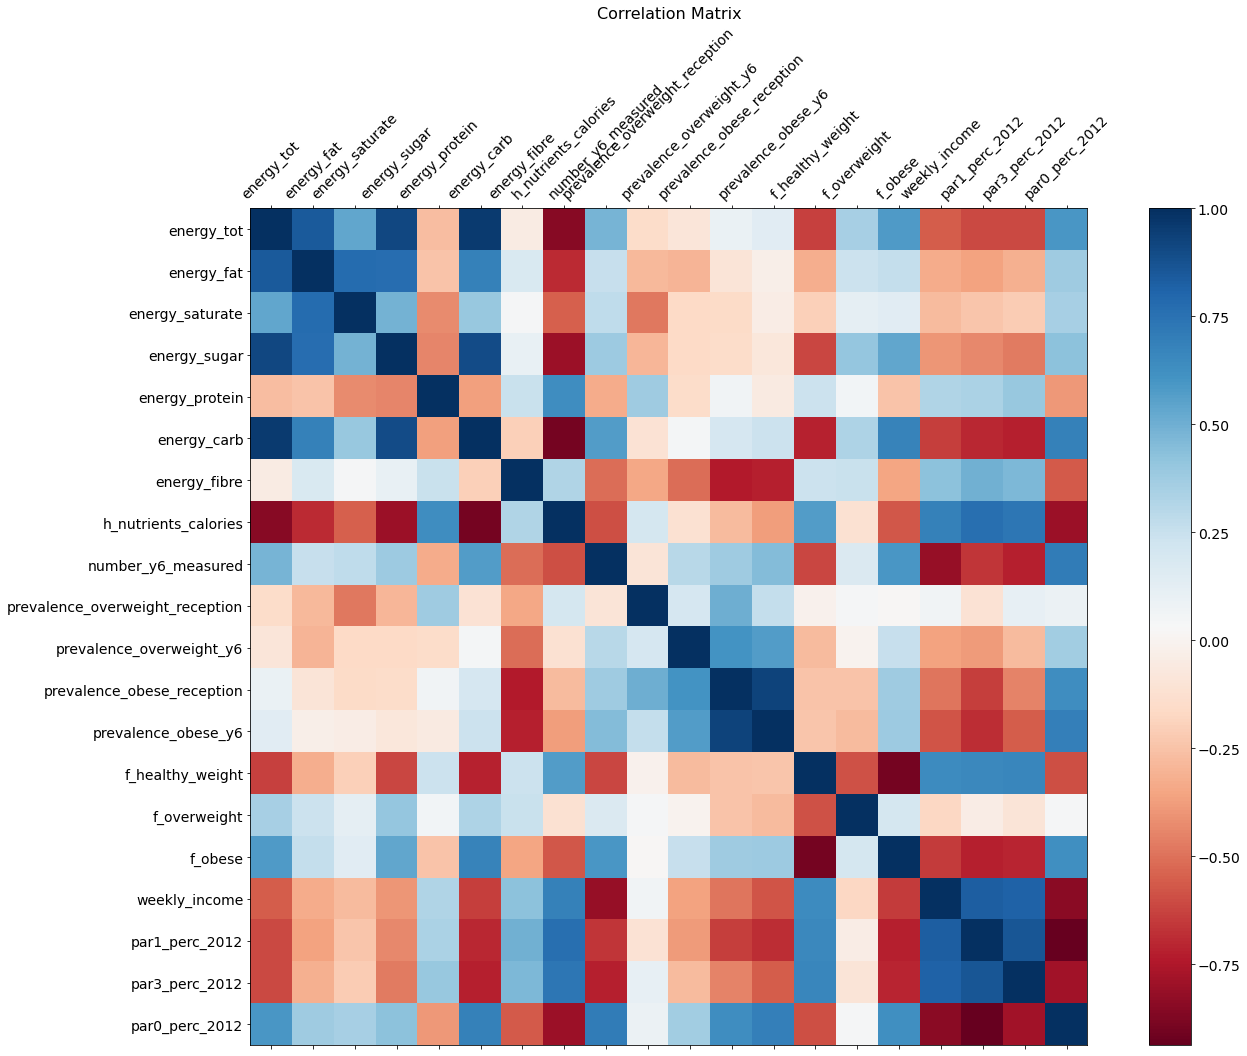

In [38]:
df = data
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(22, 15))
plt.matshow(df.corr(), fignum=f.number, cmap='RdBu')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14,)
plt.title('Correlation Matrix', fontsize=16)

# Stepwise regression

In [61]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
def stepwise_selection(X, y, 
                           initial_list=[], 
                           threshold_in=0.01, 
                           threshold_out = 0.05, 
                           verbose=True):
        """ Perform a forward-backward feature selection 
        based on p-value from statsmodels.api.OLS
        Arguments:
            X - pandas.DataFrame with candidate features
            y - list-like with the target
            initial_list - list of features to start with (column names of X)
            threshold_in - include a feature if its p-value < threshold_in
            threshold_out - exclude a feature if its p-value > threshold_out
            verbose - whether to print the sequence of inclusions and exclusions
        Returns: list of selected features 
        Always set threshold_in < threshold_out to avoid infinite looping.
        See https://en.wikipedia.org/wiki/Stepwise_regression for the details
        """
        included = list(initial_list)
        while True:
            changed=False
            # forward step
            excluded = list(set(X.columns)-set(included))
            new_pval = pd.Series(index=excluded)
            for new_column in excluded:
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
                new_pval[new_column] = model.pvalues[new_column]
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed=True
                if verbose:
                    print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

            # backward step
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
            # use all coefs except intercept
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max() # null if pvalues is empty
            if worst_pval > threshold_out:
                changed=True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
            if not changed:
                break
        return included

In [62]:
predictors_data = data.drop(columns=['h_nutrients_calories_norm', 'number_y6_measured', 'prevalence_overweight_reception', 'prevalence_overweight_y6', 'prevalence_obese_reception', 'prevalence_obese_y6', 'f_healthy_weight', 'f_overweight', 'f_obese'], axis=1)
response_data = data['f_obese']
list_predictor_select_stepwise = stepwise_selection(X=predictors_data, y=response_data,initial_list=[], 
                           threshold_in=0.6, 
                           threshold_out = 0.95, 
                           verbose=True)
print("The predictors that are selected by stepwise regression are:")
print(list_predictor_select_stepwise)

<ipython-input-61-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-61-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-61-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-61-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-61-e410ad27e6f3>:26: 

Add  par1_perc_2012                 with p-value 3.33416e-06
Add  energy_sugar                   with p-value 0.049648
Add  energy_fat                     with p-value 0.0267656
Add  energy_protein                 with p-value 0.205942
Add  energy_saturate                with p-value 0.153085
Add  par0_perc_2012                 with p-value 0.0798532
Add  energy_fibre                   with p-value 0.153375
Add  weekly_income                  with p-value 0.237374
Add  energy_carb                    with p-value 0.397939
Add  energy_tot                     with p-value 0.559866
Drop energy_protein                 with p-value 0.96806
The predictors that are selected by stepwise regression are:
['par1_perc_2012', 'energy_sugar', 'energy_fat', 'energy_saturate', 'par0_perc_2012', 'energy_fibre', 'weekly_income', 'energy_carb', 'energy_tot']


<ipython-input-61-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-61-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-61-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-61-e410ad27e6f3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-61-e410ad27e6f3>:26: 

In [65]:
multi_regression_model_1 = smf.ols(formula='f_obese ~ par1_perc_2012+par0_perc_2012+energy_carb+energy_fat+weekly_income+energy_sugar+energy_tot+energy_fibre+energy_saturate',data=data).fit()
multi_regression_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_obese   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     8.613
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           2.02e-05
Time:                        15:57:59   Log-Likelihood:                -69.582
No. Observations:                  32   AIC:                             159.2
Df Residuals:                      22   BIC:                             173.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         100.6129     47.865      2.102      0.047       1.348     199.878
par1_perc_2012   -109.3187     29.754     -3.674      0.001    -171.024     -47.613
par0_perc_2012    -61.8615     29.476     -2.099      0.048    -122.990      -0.733
energy_carb        -3.2822      1.389     -2.362      0.027      -6.164      -0.401
energy_fat         -4.8252      1.505     -3.206      0.004      -7.946      -1.704
weekly_income      -0.0173      0.013     -1.312      0.203      -0.045       0.010
energy_sugar        1.8124      0.690      2.628      0.015       0.382       3.243
energy_tot          2.9766      1.155      2.577      0.017       0.581       5.372
energy_fibre      -17.4637      9.537     -1.831      0.081     -37.242       2.314
energy_saturate     2.3701      1.225      1.934      0.066      -0.171       4.911
==============================================================================
Omnibus:                        2.464   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                1.374
Skew:                           0.170   Prob(JB):                        0.503
Kurtosis:                       2.043   Cond. No.                     7.06e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# VIF

In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def calculate_vif_(df, thresh=35):
    '''
    Calculates VIF each feature in a pandas dataframe
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with features removed
    '''
    const = add_constant(df)
    cols = const.columns
    variables = np.arange(const.shape[1])
    vif_df = pd.Series([variance_inflation_factor(const.values, i) 
               for i in range(const.shape[1])], 
              index=const.columns).to_frame()

    vif_df = vif_df.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})
    vif_df = vif_df.drop('const')
    vif_df = vif_df[vif_df['VIF'] > thresh]

    print ('Features above VIF threshold:\n')
    print (vif_df[vif_df['VIF'] > thresh])

    col_to_drop = list(vif_df.index)

    for i in col_to_drop:
        print ('Dropping: {}'.format(i))
        df = df.drop(columns=i)

    return df

In [68]:
df_predictors_select_VIF = calculate_vif_(predictors_data)
print("The columns remaining after VIF selection are:")
print(df_predictors_select_VIF.columns)

Features above VIF threshold:

                        VIF
energy_tot      4536.343156
energy_carb     2604.014438
energy_fat       494.865324
energy_protein    52.417441
Dropping: energy_tot
Dropping: energy_carb
Dropping: energy_fat
Dropping: energy_protein
The columns remaining after VIF selection are:
Index(['energy_saturate', 'energy_sugar', 'energy_fibre', 'weekly_income',
       'par1_perc_2012', 'par3_perc_2012', 'par0_perc_2012'],
      dtype='object')


In [69]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X=df_predictors_select_VIF, y=response_data)

regressor_OLS = sm.OLS(endog=response_data, exog=sm.add_constant(df_predictors_select_VIF)).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f_obese   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     6.794
Date:                Thu, 05 Aug 2021   Prob (F-statistic):           0.000169
Time:                        16:04:09   Log-Likelihood:                -76.251
No. Observations:                  32   AIC:                             168.5
Df Residuals:                      24   BIC:                             180.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             124.1437     46.641      2.662      0.014      27.882     220.405
energy_saturate    -0.4519      0.843     -0.536      0.597      -2.193       1.289
energy_sugar        0.6683      0.261      2.557      0.017       0.129       1.208
energy_fibre      -14.2350      9.789     -1.454      0.159     -34.439       5.969
weekly_income      -0.0200      0.017     -1.177      0.251      -0.055       0.015
par1_perc_2012    -87.3069     41.315     -2.113      0.045    -172.578      -2.036
par3_perc_2012      8.3506     35.511      0.235      0.816     -64.941      81.642
par0_perc_2012    -63.1422     37.539     -1.682      0.106    -140.619      14.335
==============================================================================
Omnibus:                        0.020   Durbin-Watson:                   2.429
Prob(Omnibus):                  0.990   Jarque-Bera (JB):                0.130
Skew:                           0.050   Prob(JB):                        0.937
Kurtosis:                       2.704   Cond. No.                     7.14e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.14e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Lasso

In [70]:
from sklearn import linear_model
lasso_model = linear_model.Lasso(max_iter=10e5, tol=1, normalize=True)

lasso_model.fit(X=predictors_data, y=response_data)
lasso_model.score(X=predictors_data, y=response_data)

0.0

In [71]:
df_coef_lasso = pd.DataFrame({"var": predictors_data.columns.values, "coef":lasso_model.coef_})
print(df_coef_lasso)

                var  coef
0        energy_tot   0.0
1        energy_fat   0.0
2   energy_saturate   0.0
3      energy_sugar   0.0
4    energy_protein  -0.0
5       energy_carb   0.0
6      energy_fibre  -0.0
7     weekly_income  -0.0
8    par1_perc_2012  -0.0
9    par3_perc_2012  -0.0
10   par0_perc_2012   0.0
